In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.image import pad_to_bounding_box, resize, random_crop, random_flip_left_right
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, concatenate, BatchNormalization, Activation

In [ ]:
def plot_learning_progress(train_history):
    hist = train_history.history
    x_arr = np.arange(len(hist['loss']))


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x_arr, hist['loss'], 
            '-o', label='Train Loss')
    plt.plot(x_arr, hist['val_loss'],
            '--<', label='Validation Loss')
    plt.legend(fontsize=15)


    plt.subplot(1, 2, 2)
    plt.plot(x_arr, hist['accuracy'], 
            '-o', label='Train Accuracy.')
    plt.plot(x_arr, hist['val_accuracy'], 
            '--<', label='Validation Accuracy.')
    plt.legend(fontsize=15)
    plt.show()

In [ ]:
%cd /content/drive/MyDrive/sj/dacon/cancer_transfer_prediction

/content/drive/MyDrive/sj/dacon/cancer_transfer_prediction


In [ ]:
config = {
    'IMG_SIZE': 224,
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [ ]:
df['암의 장경'] = round(df['암의 장경'].fillna(df['암의 장경'].mean()), 1)
df = df.fillna(0)
df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,18.4,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0


In [ ]:
df = df.drop(["ID", "mask_path", "수술연월일"], axis=1)
df.head()

,img_path,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,./train_imgs/BC_01_0001.png,63,1,2,1,19.0,2.0,1.0,2.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,./train_imgs/BC_01_0002.png,51,1,1,1,22.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,./train_imgs/BC_01_0003.png,37,1,2,1,18.4,2.0,0.0,0.0,0.0,...,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,./train_imgs/BC_01_0004.png,54,1,2,1,0.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,./train_imgs/BC_01_0005.png,57,1,2,1,8.0,2.0,2.0,3.0,2.0,...,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0


In [ ]:
numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ["img_path", "N_category"]
for col in df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df.head()

,img_path,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,./train_imgs/BC_01_0001.png,0.558824,1,2,1,0.172727,2.0,1.0,2.0,2.0,...,1.000,1.0,0.111111,0.123711,0.0,1.0,0.0,0.000000,0.0,0
1,./train_imgs/BC_01_0002.png,0.382353,1,1,1,0.200000,3.0,3.0,3.0,3.0,...,0.000,0.0,0.000000,0.721649,0.0,0.0,0.0,0.000000,0.0,1
2,./train_imgs/BC_01_0003.png,0.176471,1,2,1,0.167273,2.0,0.0,0.0,0.0,...,0.875,1.0,0.074074,0.072165,0.0,1.0,0.0,0.000000,0.0,0
3,./train_imgs/BC_01_0004.png,0.426471,1,2,1,0.000000,3.0,3.0,3.0,3.0,...,0.000,0.0,0.000000,0.010309,1.0,3.0,0.0,0.000000,0.0,0
4,./train_imgs/BC_01_0005.png,0.470588,1,2,1,0.072727,2.0,2.0,3.0,2.0,...,1.000,0.0,0.000000,0.082474,1.0,2.0,1.0,0.057872,0.0,0


In [ ]:
df.shape

(1000, 25)

In [ ]:
df = df.sample(frac=1, random_state=config['SEED']).reset_index(drop=True)
df_train, df_valid = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]
df_train.shape, df_valid.shape

((800, 25), (200, 25))

In [ ]:
df_train["N_category"].value_counts().sort_index()

0    397
1    403
Name: N_category, dtype: int64

In [ ]:
def generator_train():
    for item in df_train.values:
        yield (item[0], item[1:-1], item[-1])

def generator_valid():
    for item in df_valid.values:
        yield (item[0], item[1:-1], item[-1])
    
dataset_train = tf.data.Dataset.from_generator(
    generator_train,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

dataset_valid = tf.data.Dataset.from_generator(
    generator_valid,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

def augmentation(image):
    h, w = image.shape[0], image.shape[1]
    size = h if h >= w else w
    dst = pad_to_bounding_box(image, int((size-h)/2), int((size-w)/2), size, size)
    dst = resize(dst, size=(config['IMG_SIZE'], config['IMG_SIZE']))

    dst = random_flip_left_right(dst)
    dst = tf.cast(dst, tf.float32)
    dst /= 255
    
    return dst

def preprocessing(path, category, label):
    label = tf.one_hot(label, 2)
    bin = tf.io.read_file(path)
    image = tf.io.decode_png(bin, channels=3)
    image= tf.py_function(augmentation, [image], [tf.float32])
    image = tf.squeeze(image)
    return (image, category), label

dt = dataset_train.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.batch(config['BATCH_SIZE']).prefetch(3)
dv = dataset_valid.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dv.batch(config['BATCH_SIZE']).prefetch(3)

(224, 224, 3)
tf.Tensor(
[0.45588234 1.         2.         1.         0.24545455 3.
 3.         3.         3.         3.         2.         0.
 2.         0.         0.         0.         0.         0.
 0.         2.         0.         0.01212766 0.        ], shape=(23,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


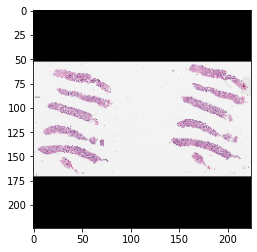

In [ ]:
for (image, clinical), label in dt.take(1):
    print(image[0].shape)
    print(clinical[0])
    print(label[0])
    plt.imshow(image[0])
    plt.show()

(224, 224, 3)
tf.Tensor(
[0.61764705 1.         1.         1.         0.3181818  2.
 3.         3.         2.         3.         0.         0.
 2.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.        ], shape=(23,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


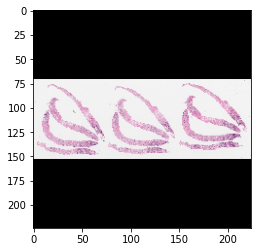

In [ ]:
for (image, clinical), label in dv.take(1):
    print(image[0].shape)
    print(clinical[0])
    print(label[0])
    plt.imshow(image[0])
    plt.show()

In [ ]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3], weights='imagenet')

input1 = Input(shape=(config['IMG_SIZE'], config['IMG_SIZE'], 3), dtype=tf.float32)

x = resnet(input1)
x = GlobalAveragePooling2D()(x) # [None, 2048]

input2 = Input(shape=(23,), dtype=tf.float32)
x = concatenate([x, input2])

x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(16)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=[input1, input2], outputs=[output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                              

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/sj/dacon/cancer_transfer_prediction/model_best.h5", 
                                        monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=10)

resnet.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Recall()])
history = model.fit((dt), epochs=10, validation_data=(dv), callbacks=[mc, es])

Epoch 1/10
     25/Unknown - 50s 1s/step - loss: 1.0844 - accuracy: 0.5437 - recall: 0.5437
Epoch 1: val_accuracy improved from -inf to 0.55500, saving model to /content/drive/MyDrive/sj/dacon/cancer_transfer_prediction/model_best.h5
25/25 [==============================] - 69s 2s/step - loss: 1.0844 - accuracy: 0.5437 - recall: 0.5437 - val_loss: 297.7403 - val_accuracy: 0.5550 - val_recall: 0.5550
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.5400 - recall: 0.5400
Epoch 2: val_accuracy did not improve from 0.55500
25/25 [==============================] - 52s 2s/step - loss: 0.9424 - accuracy: 0.5400 - recall: 0.5400 - val_loss: 46.0304 - val_accuracy: 0.4450 - val_recall: 0.4450
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.5225 - recall: 0.5225
Epoch 3: val_accuracy did not improve from 0.55500
25/25 [==============================] - 52s 2s/step - loss: 0.9302 - accuracy: 0.5225 - recall: 0.5225 -

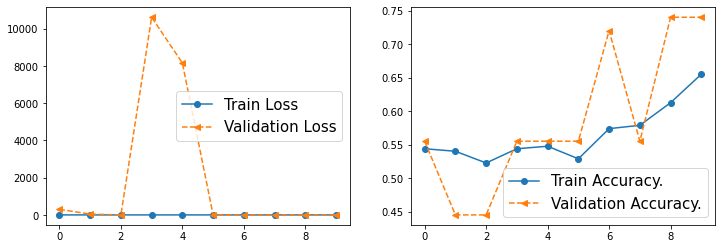

In [ ]:
plot_learning_progress(history)

In [ ]:
# subclassing model
class ImageFeature(tf.keras.Model):
    def __init__(self):
        super(ImageFeature, self).__init__()
        self.backbone = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3], weights='imagenet')
        self.backbone.trainable = True
        self.embedding = tf.keras.models.Sequential([
            GlobalAveragePooling2D(), # [None, 2048]
            Dense(1024),            
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5),
            Dense(512),            
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5),
            Dense(256),            
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5)
        ])

    def call(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        return x

class TabularFeature(tf.keras.Model):
    def __init__(self):
        super(TabularFeature, self).__init__()
        self.embedding = tf.keras.models.Sequential([
            Dense(128),
            BatchNormalization(),
            Activation('relu'),
            Dense(256),
            BatchNormalization(),
            Activation('relu'),
        ])

    def call(self, x):
        x = self.embedding(x)
        return x

class Classification(tf.keras.Model):
    def __init__(self):
        super(Classification, self).__init__()
        self.ImageFeature = ImageFeature()
        self.TabularFeature = TabularFeature()
        self.classification = tf.keras.models.Sequential([
            Dense(64),
            Activation('relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(16),
            Activation('relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(2, activation='softmax')
        ])

    def call(self, inputs, training):
        img_feature = self.ImageFeature(inputs[0])
        tabular_feature = self.TabularFeature(inputs[1])
        feature = concatenate([img_feature, tabular_feature], dim=-1)
        output = self.classification(feature)
        return output

In [ ]:
model = Classification()

call 함수를 바꿔줘야됨

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/sj/dacon/cancer_transfer_prediction/model_best.h5", 
                                        monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=10)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Recall()])
history = model.fit((dt), epochs=10, validation_data=(dv), callbacks=[mc, es])

Epoch 1/10


TypeError: ignored